In [1]:
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
DF = pd.read_csv('FERTILIZER_Merged.csv')

## Encoding the Categorical Variables
I have two methods for encoding the categorical variables. Both will work off grouped data, taking the median values returned from each WEEK <br>
 - One method will "unmelt" a dataframe completely, making each YEAR and LOCATION its own instance. <br>
 - The other method will hot-encode each categorical feature as its own column. However, this will not lead to each YEAR and LOCATION as being its own instance. This might be meaningful though, since information might be lost by the first method.
    

In [4]:
DF_grouped = DF.groupby(['YEAR','LOCATION','FERTILIZER']).median()
DF_grouped = DF_grouped.reset_index().drop('WEEK_NUM',axis=1)
DF_grouped.head()

,YEAR,LOCATION,FERTILIZER,STATE_ANSI,APPLICATIONS_IN_LB_FERTILIZER,APPLICATIONS_IN_LB_/_ACRE_/_APPLICATION_AVG_FERTILIZER,APPLICATIONS_IN_LB_/_ACRE_/_YEAR_AVG_FERTILIZER,APPLICATIONS_IN_NUMBER_AVG_FERTILIZER,TREATED_IN_PCT_OF_AREA_PLANTED_AVG_FERTILIZER,AREA_OPERATED_IN_ACRES,...,CONDITION_5_YEAR_AVG_IN_PCT_GOOD,CONDITION_5_YEAR_AVG_IN_PCT_POOR,CONDITION_5_YEAR_AVG_IN_PCT_VERY_POOR,CONDITION_5_YEAR_AVG_IN_PCT_FAIR,CONDITION_PREVIOUS_YEAR_IN_PCT_POOR,CONDITION_PREVIOUS_YEAR_IN_PCT_GOOD,CONDITION_PREVIOUS_YEAR_IN_PCT_VERY_POOR,CONDITION_PREVIOUS_YEAR_IN_PCT_EXCELLENT,CONDITION_PREVIOUS_YEAR_IN_PCT_FAIR,YIELD_IN_BU_/_ACRE
0,1996,ARKANSAS,NITROGEN,5,8200000.0,26.0,26.0,1.0,9.0,14900000.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,30.5
1,1996,ARKANSAS,PHOSPHATE,5,76400000.0,46.0,48.0,1.0,45.0,14900000.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,30.5
2,1996,ARKANSAS,POTASH,5,90500000.0,60.0,60.0,1.0,43.0,14900000.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,30.5
3,1996,ILLINOIS,NITROGEN,17,32400000.0,22.0,22.0,1.0,15.0,27900000.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,40.5
4,1996,ILLINOIS,PHOSPHATE,17,128300000.0,55.0,56.0,1.0,23.0,27900000.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,40.5


### Experiment with first method of hot-encoding a variable, this would lead to each YEAR/STATE combination having multiple rows in the dataframe, but at least information would not be lost.

In [5]:
def hot_encode_feature(dataframe,feature_to_encode) :
    
    df = dataframe.copy()
    unique_vals = DF_grouped[feature_to_encode].unique()
    to_encode = {col:[] for col in unique_vals}
    
    for i,v in df.iterrows() :
        for k,val in to_encode.items() :
            if v[feature_to_encode] == k :
                to_encode[k].append(1)
            else :
                to_encode[k].append(0)
    
    pos = df.columns.get_loc(feature_to_encode) + 1
    for k,v in to_encode.items() :
        df.insert(pos, feature_to_encode+"_"+k , v)
        pos += 1
        
    return df.drop(feature_to_encode,axis=1)

In [6]:
DF_hotencode = hot_encode_feature(DF_grouped,'FERTILIZER')

In [7]:
unique_columns = []
for c in DF_grouped.columns:
    #if c not in unused_columns+columns_edited and len(set(DF[c][:11]))!= 1:
     if len(set(DF_grouped.dropna()[c][:2])) != 1 :
        unique_columns.append(c)
        print(c," is unique")

FERTILIZER  is unique
APPLICATIONS_IN_LB_FERTILIZER  is unique
APPLICATIONS_IN_LB_/_ACRE_/_APPLICATION_AVG_FERTILIZER  is unique
APPLICATIONS_IN_LB_/_ACRE_/_YEAR_AVG_FERTILIZER  is unique
APPLICATIONS_IN_NUMBER_AVG_FERTILIZER  is unique
TREATED_IN_PCT_OF_AREA_PLANTED_AVG_FERTILIZER  is unique


In [8]:
all_columns = []
for c in DF_grouped.columns:
    if c not in unique_columns:
        all_columns.append(c)
for c in unique_columns:
    for i in range(len(DF_grouped['FERTILIZER'].unique())):
        all_columns.append(c+str(i))

In [9]:
DF_freq = DF_grouped.groupby(['YEAR', 'LOCATION']).size().reset_index(name='Freq')

In [10]:
DF_new=np.zeros((DF_grouped.groupby(['YEAR', 'LOCATION']).size().shape[0],len(all_columns)),dtype='object')

row = 0
new_row = 0
while row <= DF_grouped.shape[0] - DF_freq['Freq'].iloc[-1]:
    subbed_len = DF_freq['Freq'][new_row]
    count=0
    for c in all_columns:
        if c in DF_grouped.columns:
            DF_new[new_row][count] = DF_grouped[c][row]
            count+=1
    for c in unique_columns:
        for j in range(DF_freq['Freq'].max()):
            if j < subbed_len :
                DF_new[new_row][count] = DF_grouped[c][row+j]
            else :
                DF_new[new_row][count] = np.nan
            count+=1  
    row = row + subbed_len
    new_row += 1
DF_new = pd.DataFrame(DF_new,columns=all_columns)

In [11]:
def missing_data(dataframe) :
    for col in dataframe.columns :
        percent = sum(pd.isna(dataframe[col]))/dataframe.shape[0]
        print('Percent Misssing Data in Column {} : {}'.format(col,percent))

In [12]:
missing_data(DF_new)

Percent Misssing Data in Column YEAR : 0.0
Percent Misssing Data in Column LOCATION : 0.0
Percent Misssing Data in Column STATE_ANSI : 0.0
Percent Misssing Data in Column AREA_OPERATED_IN_ACRES : 0.0
Percent Misssing Data in Column AREA_OPERATED_IN_ACRES_/_OPERATION : 0.0
Percent Misssing Data in Column OPERATIONS_IN_OPERATIONS : 0.0
Percent Misssing Data in Column AREA_HARVESTED_IN_ACRES : 0.0
Percent Misssing Data in Column AREA_PLANTED_IN_ACRES : 0.0
Percent Misssing Data in Column PRODUCTION_IN_BU : 0.0
Percent Misssing Data in Column PRODUCTION_IN_$ : 0.04716981132075472
Percent Misssing Data in Column PRICE_RECEIVED_IN_$_/_BU : 0.0
Percent Misssing Data in Column CONDITION_IN_PCT_VERY_POOR : 0.03773584905660377
Percent Misssing Data in Column CONDITION_IN_PCT_GOOD : 0.03773584905660377
Percent Misssing Data in Column CONDITION_IN_PCT_FAIR : 0.03773584905660377
Percent Misssing Data in Column CONDITION_IN_PCT_POOR : 0.03773584905660377
Percent Misssing Data in Column CONDITION_IN_

In [13]:
DF_new = DF_new.infer_objects()

## The two final datasets that we have the option to work with are listed below (with .head() command). Need to decide the best way to move forward. This will easily be built out to HERBICIDES, INSECTICIDES, FUNGICIDE as well (only experimented with fertilizer for now)

In [14]:
DF_hotencode.head()

,YEAR,LOCATION,FERTILIZER_NITROGEN,FERTILIZER_PHOSPHATE,FERTILIZER_POTASH,FERTILIZER_SULFUR,STATE_ANSI,APPLICATIONS_IN_LB_FERTILIZER,APPLICATIONS_IN_LB_/_ACRE_/_APPLICATION_AVG_FERTILIZER,APPLICATIONS_IN_LB_/_ACRE_/_YEAR_AVG_FERTILIZER,...,CONDITION_5_YEAR_AVG_IN_PCT_GOOD,CONDITION_5_YEAR_AVG_IN_PCT_POOR,CONDITION_5_YEAR_AVG_IN_PCT_VERY_POOR,CONDITION_5_YEAR_AVG_IN_PCT_FAIR,CONDITION_PREVIOUS_YEAR_IN_PCT_POOR,CONDITION_PREVIOUS_YEAR_IN_PCT_GOOD,CONDITION_PREVIOUS_YEAR_IN_PCT_VERY_POOR,CONDITION_PREVIOUS_YEAR_IN_PCT_EXCELLENT,CONDITION_PREVIOUS_YEAR_IN_PCT_FAIR,YIELD_IN_BU_/_ACRE
0,1996,ARKANSAS,1,0,0,0,5,8200000.0,26.0,26.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,30.5
1,1996,ARKANSAS,0,1,0,0,5,76400000.0,46.0,48.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,30.5
2,1996,ARKANSAS,0,0,1,0,5,90500000.0,60.0,60.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,30.5
3,1996,ILLINOIS,1,0,0,0,17,32400000.0,22.0,22.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,40.5
4,1996,ILLINOIS,0,1,0,0,17,128300000.0,55.0,56.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,40.5


In [15]:
DF_new.head()

,YEAR,LOCATION,STATE_ANSI,AREA_OPERATED_IN_ACRES,AREA_OPERATED_IN_ACRES_/_OPERATION,OPERATIONS_IN_OPERATIONS,AREA_HARVESTED_IN_ACRES,AREA_PLANTED_IN_ACRES,PRODUCTION_IN_BU,PRODUCTION_IN_$,...,APPLICATIONS_IN_LB_/_ACRE_/_YEAR_AVG_FERTILIZER2,APPLICATIONS_IN_LB_/_ACRE_/_YEAR_AVG_FERTILIZER3,APPLICATIONS_IN_NUMBER_AVG_FERTILIZER0,APPLICATIONS_IN_NUMBER_AVG_FERTILIZER1,APPLICATIONS_IN_NUMBER_AVG_FERTILIZER2,APPLICATIONS_IN_NUMBER_AVG_FERTILIZER3,TREATED_IN_PCT_OF_AREA_PLANTED_AVG_FERTILIZER0,TREATED_IN_PCT_OF_AREA_PLANTED_AVG_FERTILIZER1,TREATED_IN_PCT_OF_AREA_PLANTED_AVG_FERTILIZER2,TREATED_IN_PCT_OF_AREA_PLANTED_AVG_FERTILIZER3
0,1996,ARKANSAS,5,14900000.0,301.0,49500.0,3600000.0,3650000.0,109800000.0,7.554240e+08,...,60.0,NaN,1.0,1.0,1.0,NaN,9.0,45.0,43.0,NaN
1,1996,ILLINOIS,17,27900000.0,353.0,79000.0,9850000.0,9900000.0,398925000.0,3.011884e+09,...,99.0,NaN,1.0,1.0,1.0,NaN,15.0,23.0,34.0,NaN
2,1996,INDIANA,18,15600000.0,236.0,66000.0,5300000.0,5350000.0,230550000.0,1.519325e+09,...,102.0,NaN,1.2,1.0,1.0,NaN,23.0,33.0,44.0,NaN
3,1996,IOWA,19,33000000.0,333.0,99000.0,9450000.0,9500000.0,415800000.0,3.060288e+09,...,76.0,NaN,1.0,1.0,1.0,NaN,8.0,12.0,14.0,NaN
4,1996,LOUISIANA,22,8300000.0,277.0,30000.0,1350000.0,1400000.0,39150000.0,2.732670e+08,...,70.0,NaN,1.0,1.0,1.0,NaN,4.0,36.0,34.0,NaN


## Just messed around with correlation

In [16]:
corr = DF_new.corr()
pd.DataFrame(corr['YIELD_IN_BU_/_ACRE']).reset_index().sort_values('YIELD_IN_BU_/_ACRE')

,index,YIELD_IN_BU_/_ACRE
13,CONDITION_IN_PCT_POOR,-0.242013
12,CONDITION_IN_PCT_FAIR,-0.231217
30,APPLICATIONS_IN_LB_/_ACRE_/_APPLICATION_AVG_FE...,-0.224008
16,CONDITION_5_YEAR_AVG_IN_PCT_GOOD,-0.215799
19,CONDITION_5_YEAR_AVG_IN_PCT_FAIR,-0.196796
24,CONDITION_PREVIOUS_YEAR_IN_PCT_FAIR,-0.159387
34,APPLICATIONS_IN_LB_/_ACRE_/_YEAR_AVG_FERTILIZER0,-0.153645
21,CONDITION_PREVIOUS_YEAR_IN_PCT_GOOD,-0.126196
1,STATE_ANSI,-0.121525
10,CONDITION_IN_PCT_VERY_POOR,-0.118334


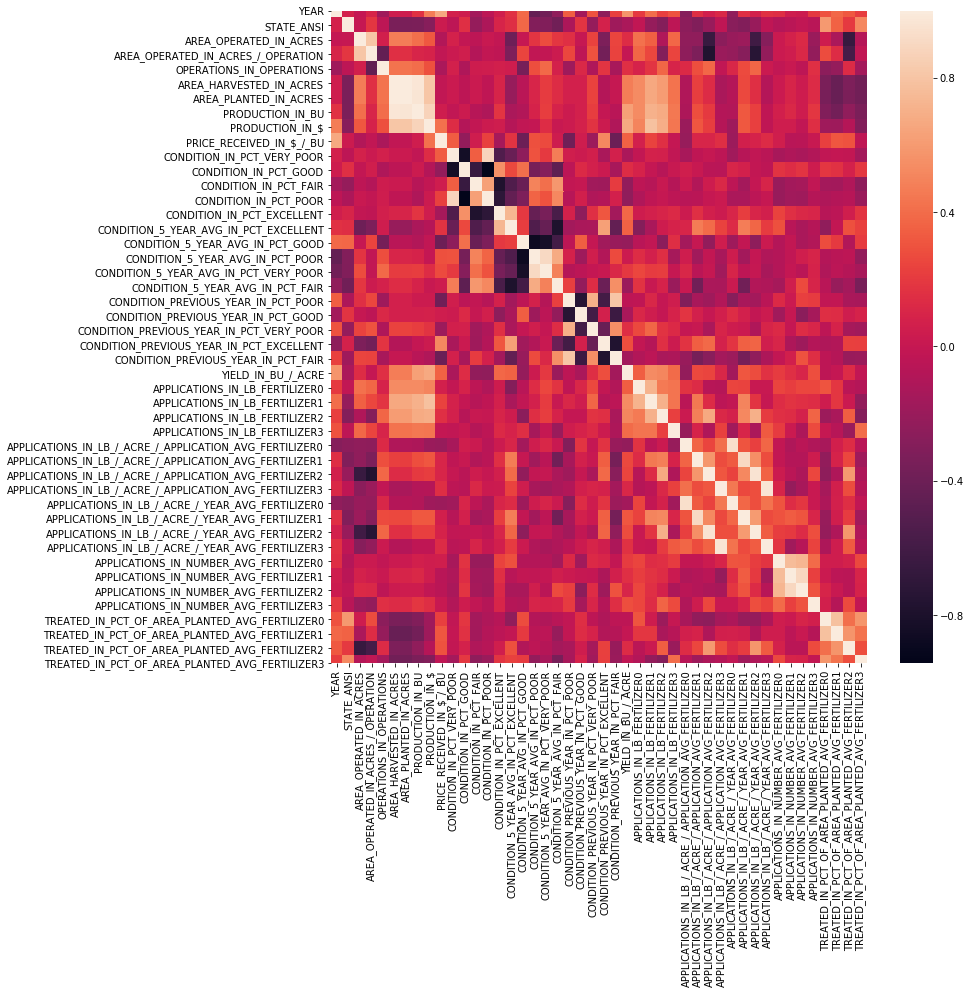

In [17]:
plt.figure(figsize=(12,12))
sns.heatmap(corr)
plt.show()

In [18]:
bushels_per_year = DF.groupby(['LOCATION','YEAR'])['YIELD_IN_BU_/_ACRE'].mean()
bushels_per_year = bushels_per_year.reset_index()

Messy, but each line represents the trend of YIELD for each state in the dataset


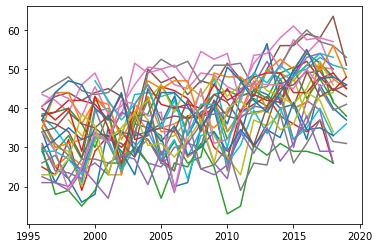

In [19]:
for state in bushels_per_year['LOCATION'].unique() :
    subbed_df = bushels_per_year[bushels_per_year['LOCATION'] == state]
    plt.plot(subbed_df['YEAR'],subbed_df['YIELD_IN_BU_/_ACRE'])
#plt.legend(labels = bushels_per_year['LOCATION'].unique(),loc='lower right')
print('Messy, but each line represents the trend of YIELD for each state in the dataset')
plt.show()